In [ ]:
# LightGBM Model - Bitcoin Price Prediction
# Gerekli paketler: Ana dizindeki requirements.txt dosyasından yüklü olmalı
# Kurulum: pip install -r ../requirements.txt


1. LIGHTGBM İÇİN VERİ HAZIRLANIYOR...

2. LIGHTGBM TUNING BAŞLIYOR...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✓ EN İYİ PARAMETRELER: {'subsample': 0.7, 'num_leaves': 20, 'n_estimators': 1000, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

3. METRİKLER VE TAHMİN...
   • Metrikler kaydedildi: lgbm_metrics.csv

4. GELECEK 30 GÜN SİMÜLASYONU...

5. GRAFİKLER KAYDEDİLİYOR...


c:\xampp\htdocs\Advanced-BTC-Prediction-main\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\xampp\htdocs\Advanced-BTC-Prediction-main\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\xampp\htdocs\Advanced-BTC-Prediction-main\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\xampp\htdocs\Advanced-BTC-Prediction-main\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\xampp\htdocs\Advanced-BTC-Prediction-main\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not h


✓ LIGHTGBM MODELİ TAMAMLANDI.


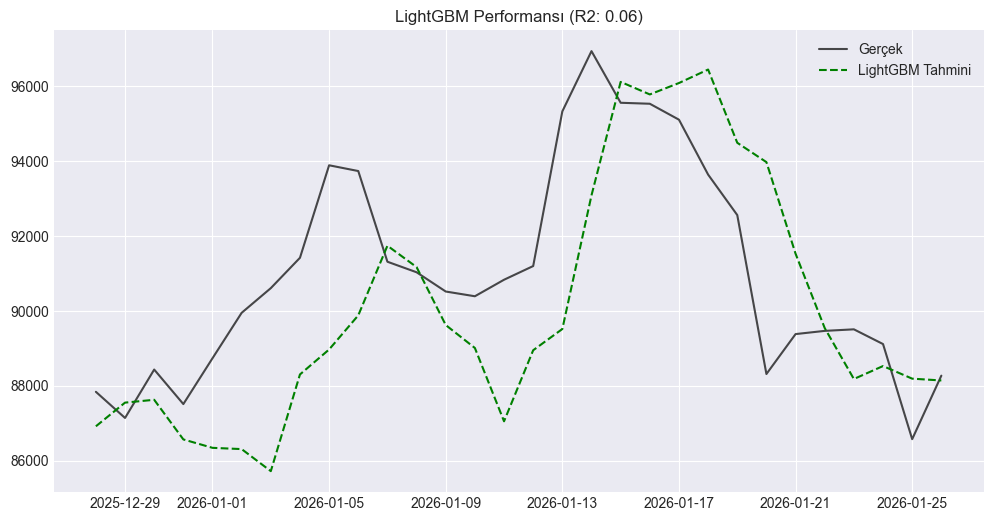

<Figure size 1000x800 with 0 Axes>

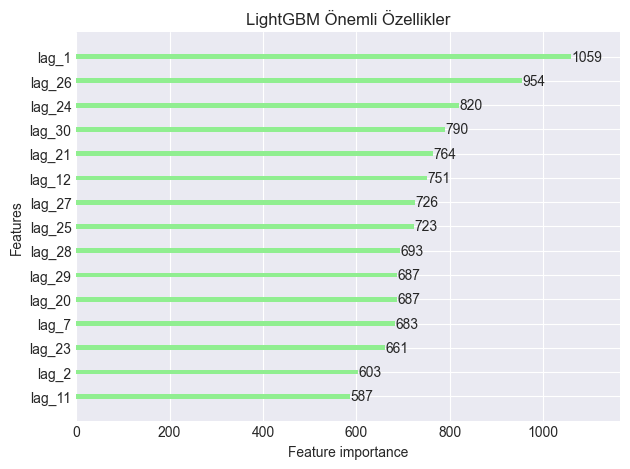

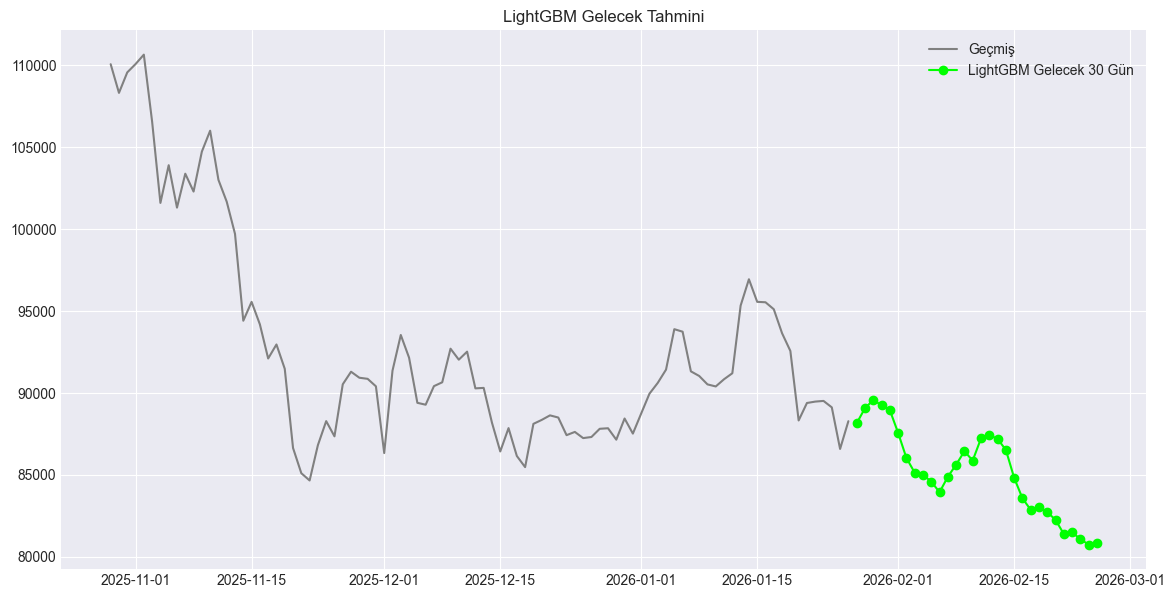

In [2]:
# =============================================================================
# MODEL 3: LIGHTGBM (Light Gradient Boosting Machine)
# Final Projesi - Advanced Model 3
# =============================================================================

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb  # LightGBM kütüphanesi

from datetime import date, timedelta
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Görselleştirme Ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("winter")

# 1. VERİ HAZIRLAMA
print("1. LIGHTGBM İÇİN VERİ HAZIRLANIYOR...")

today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (today - timedelta(days=1095)).strftime("%Y-%m-%d") # 3 Yıl

try:
    df = yf.download('BTC-USD', start=start_date, end=end_date, progress=False, threads=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.reset_index(inplace=True)
except:
    df = pd.DataFrame()

data = df[['Date', 'Close']].copy()

# Feature Engineering: Lag Features (30 Gün)
n_lags = 30
for i in range(1, n_lags + 1):
    data[f'lag_{i}'] = data['Close'].shift(i)

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
last_known_row = data.iloc[-1]

# Train-Test Split
test_days = 30
train_data = data.iloc[:-test_days]
test_data = data.iloc[-test_days:]

feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)]
X_train = train_data[feature_cols]
y_train = train_data['Close']
X_test = test_data[feature_cols]
y_test = test_data['Close']

# 2. HYPERPARAMETER TUNING
print("\n2. LIGHTGBM TUNING BAŞLIYOR...")

# LightGBM Parametre Uzayı
lgb_params = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],       # Ağaç karmaşıklığı
    'max_depth': [-1, 10, 20],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)
model = lgb.LGBMRegressor(random_state=42, verbose=-1)

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=lgb_params,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print(f"\n✓ EN İYİ PARAMETRELER: {search.best_params_}")

# Modeli Kaydet
joblib.dump(best_model, 'lgbm_model_final.pkl')

# 3. PERFORMANS
print("\n3. METRİKLER VE TAHMİN...")
y_pred = best_model.predict(X_test)

metrics = {
    "Model": "LightGBM",
    "R2 Score": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred)
}

pd.DataFrame([metrics]).to_csv("lgbm_metrics.csv", index=False)
print("   • Metrikler kaydedildi: lgbm_metrics.csv")

# 4. GELECEK TAHMİNİ
print("\n4. GELECEK 30 GÜN SİMÜLASYONU...")
future_preds = []
current_features = last_known_row[feature_cols].values.reshape(1, -1)

for i in range(30):
    pred = best_model.predict(current_features)[0]
    future_preds.append(pred)
    new_features = np.roll(current_features, 1)
    new_features[0, 0] = pred
    current_features = new_features

last_date = data['Date'].max()
future_dates = [last_date + timedelta(days=x) for x in range(1, 31)]
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_preds})
forecast_df.to_csv('lgbm_future_forecast.csv', index=False)

# 5. GÖRSELLEŞTİRME
print("\n5. GRAFİKLER KAYDEDİLİYOR...")

# Grafik 1: Test Prediction
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], y_test, label='Gerçek', color='black', alpha=0.7)
plt.plot(test_data['Date'], y_pred, label='LightGBM Tahmini', color='green', linestyle='--')
plt.title(f'LightGBM Performansı (R2: {metrics["R2 Score"]:.2f})')
plt.legend()
plt.savefig('lgbm_1_test_prediction.png')

# Grafik 2: Feature Importance
plt.figure(figsize=(10, 8))
lgb.plot_importance(best_model, max_num_features=15, title='LightGBM Önemli Özellikler', color='lightgreen')
plt.tight_layout()
plt.savefig('lgbm_2_feature_importance.png')

# Grafik 3: Future Forecast
plt.figure(figsize=(14, 7))
hist_df = data.iloc[-90:]
plt.plot(hist_df['Date'], hist_df['Close'], label='Geçmiş', color='gray')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='LightGBM Gelecek 30 Gün', color='lime', marker='o')
plt.title('LightGBM Gelecek Tahmini')
plt.legend()
plt.savefig('lgbm_3_future_forecast.png')

print("\n✓ LIGHTGBM MODELİ TAMAMLANDI.")